# DACON - 쇼핑몰 지점별 매출액 예측 경진대회
## Model - Regression
### Data
[DACON - 쇼핑몰 지점별 매출액 예측 경진대회](https://dacon.io/competitions/official/235942/data)

### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import glob

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

c:\Users\spec3\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Data Load

In [2]:
train = pd.read_csv("data/pre_train.csv")
test = pd.read_csv("data/pre_test.csv")

train.shape, test.shape

((6255, 18), (180, 17))

### 인코딩

In [3]:
train = pd.get_dummies(train, columns=["Unemployment"])
test = pd.get_dummies(test, columns=["Unemployment"])

### 데이터셋 나누기

In [4]:
label = "Weekly_Sales_log1p"
features = train.columns.tolist()
features.remove(label)
features.remove("id")
features.remove("Date")
features.remove("Weekly_Sales")
features.remove("Temperature")
features

['Store',
 'Fuel_Price',
 'Promotion1',
 'Promotion2',
 'Promotion3',
 'Promotion4',
 'Promotion5',
 'IsHoliday',
 'Year',
 'Month',
 'Day',
 'Cel',
 'Unemployment_High',
 'Unemployment_Low',
 'Unemployment_Middle']

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.2)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (5004, 15)
y_train: (5004,)
X_test: (1251, 15)
y_val: (1251,)


### Model
#### Random Forest

In [6]:
reg_rf = RandomForestRegressor()

pred_rf = reg_rf.fit(X_train, y_train).predict(X_val)

mean_squared_error(y_val, pred_rf)

0.013858126953444934

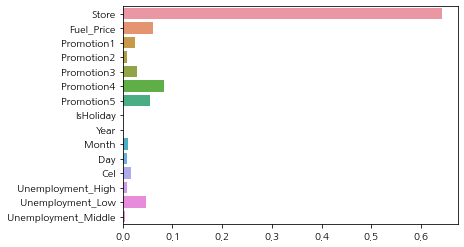

In [7]:
_ = sns.barplot(x=reg_rf.feature_importances_, y=reg_rf.feature_names_in_)

#### Catboost

In [8]:
reg_cb = CatBoostRegressor(verbose=0)

pred_cb = reg_cb.fit(X_train, y_train).predict(X_val)

mean_squared_error(y_val, pred_cb)

0.006702764929665284

#### XGBoost

In [9]:
reg_xgb = XGBRegressor()

pred_xgb = reg_xgb.fit(X_train, y_train).predict(X_val)

mean_squared_error(y_val, pred_xgb)

0.007517993250503564

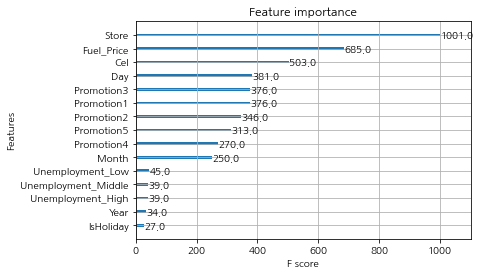

In [10]:
_ = xgb.plot_importance(reg_xgb)

#### LGBM

In [11]:
reg_lgbm = LGBMRegressor()

pred_lgbm = reg_lgbm.fit(X_train, y_train).predict(X_val)

mean_squared_error(y_val, pred_lgbm)

0.009255447062714393

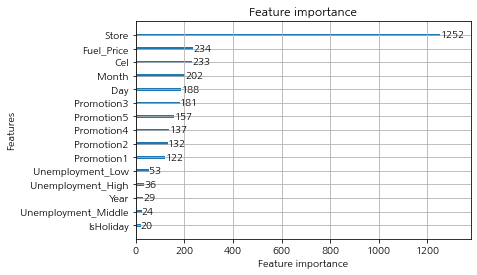

In [12]:
_ = lgbm.plot_importance(reg_lgbm)

#### Stacking

In [13]:
pred_stacking = (0.25*pred_rf) + (0.25*pred_cb) + (0.25*pred_xgb) + (0.25*pred_lgbm)

np.sqrt(mean_squared_error(y_val, pred_stacking))

0.08181326715540312

### Submit

In [14]:
sub = pd.read_csv("data/sample_submission.csv")
sub.head()

,id,Weekly_Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [15]:
sub["Weekly_Sales"] = np.expm1((0.25*reg_rf.predict(test[features])) + (0.25*reg_cb.predict(test[features])) + (0.25*reg_xgb.predict(test[features])) + (0.25*reg_lgbm.predict(test[features])))
sub.to_csv("sub_stacking_rmse_08_excID.csv", index=False)

In [16]:
sub["Weekly_Sales"] = np.expm1(reg_cb.predict(test[features]))
sub.to_csv("sub_cat_rmse_007_excID.csv", index=False)